# Dataset Creation of "easy" CUDA kernels to query 

This notebook grabs the profiling data for the CUDA kernels that we've identified as being "easy" for our prediction pipeline to classify.

In [43]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tiktoken
from tqdm import tqdm
import csv

In [44]:
# Load the classification results
with open('manually_classified_CUDA_kernels.json', 'r') as f:
    data = json.load(f)

In [45]:
# Parse the loaded JSON (in variable `data`) into a DataFrame of manual classifications
# Expected JSON structure:
# {
#   "categories": [...],
#   "classifications": { "target|filepath|idx": { categoryFlagName: bool, ... }, ... }
# }

categories = data.get('categories', [])
classifications = data.get('classifications', {})

records = []
for composite_key, flags in classifications.items():
    # Split the composite key into its components (robust to extra '|')
    parts = composite_key.split('|')
    target_name = parts[0] if len(parts) > 0 else None
    file_path = parts[1] if len(parts) > 1 else None
    kernel_idx_raw = parts[2] if len(parts) > 2 else None
    try:
        kernel_idx = int(kernel_idx_raw) if kernel_idx_raw is not None else None
    except ValueError:
        kernel_idx = kernel_idx_raw  # leave as string if not int

    row = {
        'targetName': target_name,
        'filepath': file_path,
        'kernel_index': kernel_idx,
    }
    # Ensure all categories appear (even if missing in a particular entry)
    for cat in categories:
        row[cat] = flags.get(cat, None)

    records.append(row)

manual_df = pd.DataFrame(records)

# Create normalized / pythonic boolean columns for easier filtering
import re

def normalize(col: str) -> str:
    # remove leading numeric labels like '1: '
    col_wo_prefix = re.sub(r'^\d+:\s*', '', col)
    return (col_wo_prefix.lower()
            .replace(' ', '_')
            .replace('-', '_')
            .replace('/', '_')
            .replace('__', '_'))

normalized_map = {cat: normalize(cat) for cat in categories}
normalized_map.pop('9: Missing Some Code')

for original, norm in normalized_map.items():
    if original in manual_df.columns:
        manual_df[norm] = manual_df[original].astype(bool)

# Reorder columns: identifiers first, then original category names, then normalized names
original_cat_cols = categories
#normalized_cols = [normalized_map[c] for c in categories]
normalized_cols = list(normalized_map.values())
ordered_cols = ['targetName', 'filepath', 'kernel_index'] + original_cat_cols + normalized_cols
manual_df = manual_df[ordered_cols]

print(f"Parsed {manual_df.shape[0]} classified kernels with {len(categories)} feature flags.")
manual_df.head()

Parsed 521 classified kernels with 9 feature flags.


,targetName,filepath,kernel_index,1: Has Warp Divergence,2: Has Data-Dependent Warp Divergence,3: Has FLOP Division,4: Calls EXTERNAL or LIB function,5: Calls DEVICE function,6: Calls special math function,7: Has Common Subexpression,8: Has Recursion,9: Missing Some Code,has_warp_divergence,has_data_dependent_warp_divergence,has_flop_division,calls_external_or_lib_function,calls_device_function,calls_special_math_function,has_common_subexpression,has_recursion
0,aligned-types-cuda,/Users/gbolet/hecbench-roofline/src/aligned-ty...,0,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
1,particlefilter-cuda,/Users/gbolet/hecbench-roofline/src/particlefi...,0,True,False,True,False,False,True,False,False,False,True,False,True,False,False,True,False,False
2,particlefilter-cuda,/Users/gbolet/hecbench-roofline/src/particlefi...,0,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
3,particlefilter-cuda,/Users/gbolet/hecbench-roofline/src/particlefi...,0,True,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False
4,particlefilter-cuda,/Users/gbolet/hecbench-roofline/src/particlefi...,0,True,True,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False


/var/folders/3g/gqtlwym54qj00m_k586jkf0w0000gn/T/ipykernel_72011/1984192966.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='feature', y='count', data=feature_counts_df, palette='Blues_d')


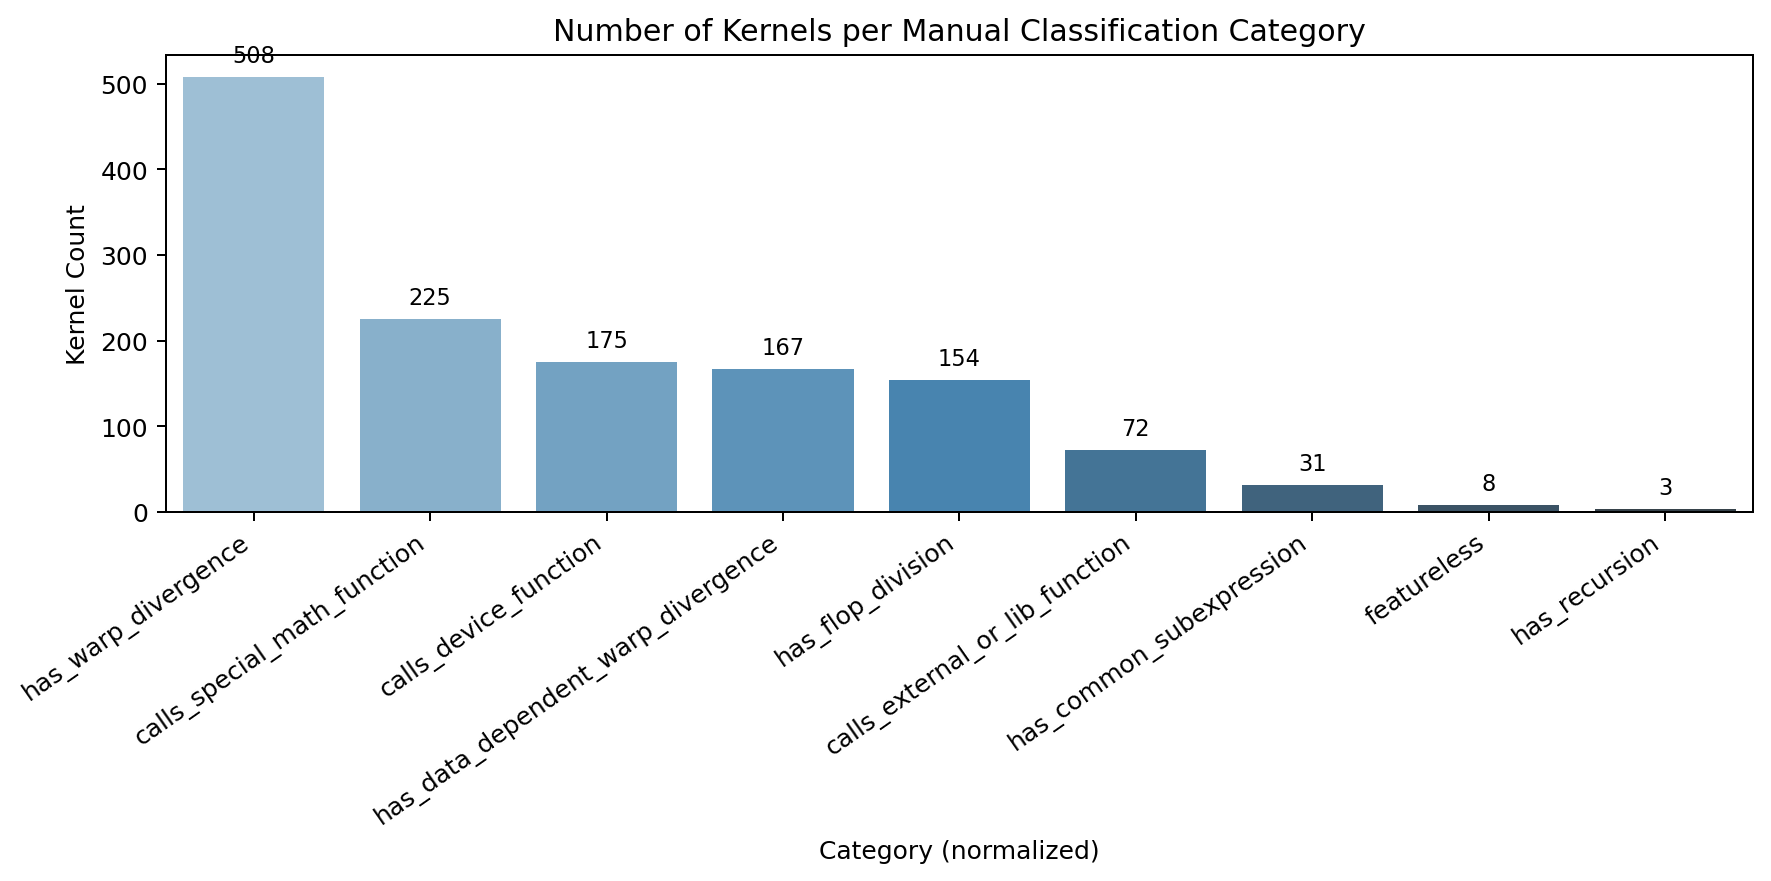

,feature,count
0,has_warp_divergence,508
1,calls_special_math_function,225
2,calls_device_function,175
3,has_data_dependent_warp_divergence,167
4,has_flop_division,154


In [46]:
# Barplot: count of codes per (normalized) category (+ featureless case)
# Use the normalized boolean columns created earlier (normalized_cols)

assert 'manual_df' in globals(), "manual_df not found. Run previous cell first."
assert 'normalized_cols' in globals(), "normalized_cols list not found."

# Ensure columns exist
existing_norm_cols = [c for c in normalized_cols if c in manual_df.columns]

# Sum booleans (True counts) per feature
feature_counts_df = (manual_df[existing_norm_cols]
                     .astype(int)
                     .sum()
                     .reset_index())
feature_counts_df.columns = ['feature', 'count']

# Add the featureless category: rows where all normalized features are False
featureless_count = (manual_df[existing_norm_cols].astype(int).sum(axis=1) == 0).sum()
feature_counts_df = pd.concat([
    feature_counts_df,
    pd.DataFrame([{'feature': 'featureless', 'count': featureless_count}])
], ignore_index=True)

# Order by count descending (featureless included)
feature_counts_df = feature_counts_df.sort_values('count', ascending=False, ignore_index=True)

plt.figure(figsize=(10, 5), dpi=180)
ax = sns.barplot(x='feature', y='count', data=feature_counts_df, palette='Blues_d')
plt.title('Number of Kernels per Manual Classification Category')
plt.xlabel('Category (normalized)')
plt.ylabel('Kernel Count')
plt.xticks(rotation=35, ha='right')

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}',
                (p.get_x() + p.get_width()/2., height),
                ha='center', va='bottom', fontsize=9, xytext=(0,4), textcoords='offset points')

plt.tight_layout()
plt.show()

feature_counts_df.head()

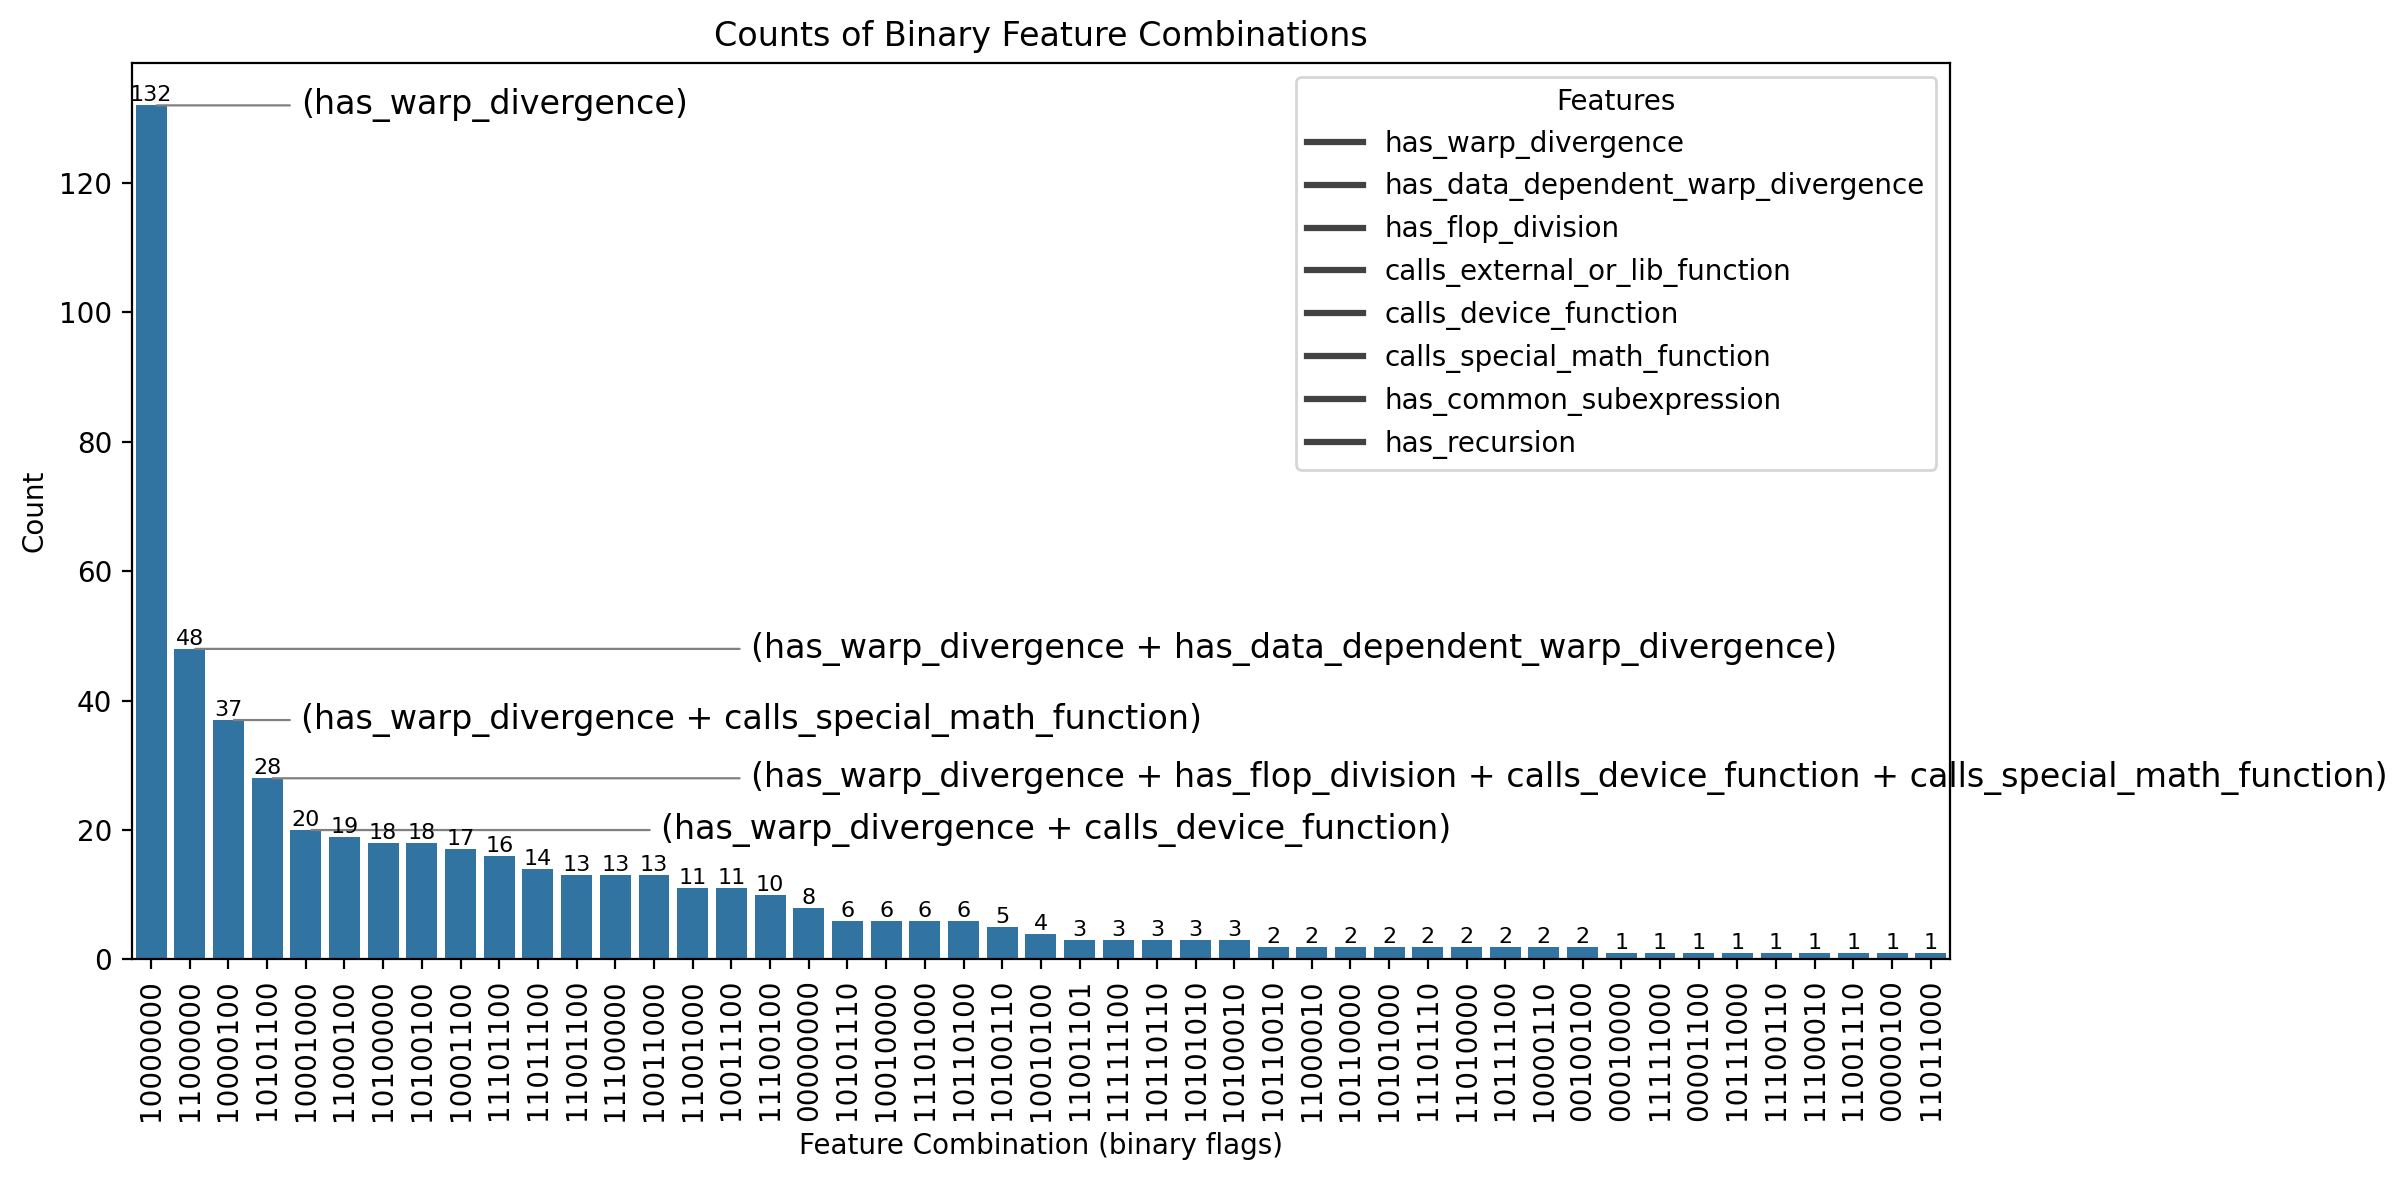

In [47]:
import textwrap

df_grouped = manual_df.groupby(normalized_cols).size().reset_index(name='count')
df_grouped_sorted = df_grouped[df_grouped['count'] > 0].sort_values(by='count', ascending=False)

df_grouped_sorted['combination'] = df_grouped_sorted[normalized_cols].apply(
    lambda row: ''.join(row.astype(int).astype(str)), axis=1)

plt.figure(figsize=(12, 6), dpi=200)
ax = sns.barplot(x='combination', y='count', data=df_grouped_sorted)
plt.title('Counts of Binary Feature Combinations')
plt.xlabel('Feature Combination (binary flags)')
plt.ylabel('Count')
plt.xticks(rotation=90, ha='center')

# Annotate feature tuples (first four only) at right edge inside plot with arrows, and counts above bars
xlim = ax.get_xlim()
ylim = ax.get_ylim()
# shift label_x slightly inside the right boundary
label_x = xlim[1] - (xlim[1] - xlim[0]) * 0.05
# define stagger offsets to prevent text overlap
stagger_offsets = [0, xlim[1]/4, 0, xlim[1]/4, xlim[1]/5]  # stagger offsets for the first five bars

for i, (p, (_, row)) in enumerate(zip(ax.patches, df_grouped_sorted.iterrows())):
    height = p.get_height()
    feature_names = [name for name, flag in zip(normalized_cols, row[normalized_cols]) if flag]
    tuple_text = f"({' + '.join(feature_names)})" if feature_names else '()'
    # draw arrow annotation for first five bars
    if i < 5:
        ax.annotate(tuple_text,
                    xy=(p.get_x() + p.get_width()/2, height),
                    xytext=(xlim[1]/12+stagger_offsets[i], height),
                    ha='left', va='center', color='black', fontsize=12,
                    arrowprops=dict(arrowstyle='-', color='gray', lw=0.8))
    # annotate count above bar
    ax.annotate(f"{int(height)}",
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', color='black', fontsize=8)

ax.legend(normalized_cols, title='Features')
plt.tight_layout()
plt.show()

In [5]:
# Flatten classification_results.json into DataFrame
import hashlib
rows = []
for program_name, files_dict in data.items():
    for filename, entries in files_dict.items():
        for entry_dict in entries:
            row = {
                'program_name': program_name,
                'filename': filename,
                'source_code': entry_dict.get('source_code', '')
            }
            # Compute MD5 hash of the source code
            row['code_hash'] = hashlib.md5(row['source_code'].encode('utf-8')).hexdigest()
            # Merge with other entry fields
            row = row | entry_dict

            rows.append(row)

df_codes = pd.DataFrame(rows)

# let's add a row that combines the program_name and global_function_name
# should be in string tuple format ('program_name', 'global_function_name')
df_codes['combined_name'] = df_codes.apply(lambda row: f"({row['program_name']}, {row['global_function_name']})", axis=1)

df_codes.head()

,program_name,filename,source_code,code_hash,has_float_division,float_division_line_num,has_external_function_calls,external_function_call_line_num,has_recursion,recursion_line_num,has_warp_divergence,warp_divergence_line_num,has_data_dependent_warp_divergence,data_dependent_warp_divergence_line_num,has_common_subexpression,common_subexpression_line_num,has_special_math_function,special_math_function_line_num,global_function_name,combined_name
0,aligned-types-cuda,/Users/gbolet/hecbench-roofline/src/aligned-ty...,__global__ void testKernel(\n TData *...,8988ce6b085ab497fe6863ef87854bc7,False,[],False,[],False,[],True,[8],False,[],False,[],False,[],testKernel,"(aligned-types-cuda, testKernel)"
1,particlefilter-cuda,/Users/gbolet/hecbench-roofline/src/particlefi...,inline __host__ __device__ int4 make_int4(floa...,6793c8ca5b53d0a2f764867525ed5fcf,True,"[59, 95, 61, 63, 67, 69]",False,[],True,"[3, 8, 8, 8, 8, 13, 18, 18, 18, 18, 23, 23, 23...",True,"[55, 76, 105, 113, 78, 92, 101, 107, 88, 82, 83]",True,"[88, 82, 83]",True,"[61, 63, 64, 67, 69, 70]",True,"[8, 18, 23, 61, 63, 64, 67, 69, 70, 87, 97]",kernel_likelihood,"(particlefilter-cuda, kernel_likelihood)"
2,particlefilter-cuda,/Users/gbolet/hecbench-roofline/src/particlefi...,__global__ void\nkernel_sum (float* partial_su...,9fa3bf715227d7d2e7a02c288285d0a4,False,[],False,[],False,[],True,[7],False,[],False,[],False,[],kernel_sum,"(particlefilter-cuda, kernel_sum)"
3,particlefilter-cuda,/Users/gbolet/hecbench-roofline/src/particlefi...,inline __host__ __device__ float4 make_float4(...,062c5edef05d5965fdffa129a86f4cf9,True,"[28, 52, 38, 40, 41]",False,[],True,"[3, 8, 8, 8, 8]",True,"[24, 27, 31, 46, 50, 33]",False,[],True,"[38, 40, 41, 52]",True,"[8, 38, 40, 42]",kernel_normalize_weights,"(particlefilter-cuda, kernel_normalize_weights)"
4,particlefilter-cuda,/Users/gbolet/hecbench-roofline/src/particlefi...,__global__ void\nkernel_find_index (\n cons...,f775eb09d1b2ce46e940523a6b21bf98,False,[],False,[],False,[],True,"[12, 16, 22, 17]",True,[17],False,[],False,[],kernel_find_index,"(particlefilter-cuda, kernel_find_index)"


In [6]:
# check for any collisions in the code hashes
hash_collisions = df_codes[df_codes.duplicated(['code_hash'], keep=False)]
print(hash_collisions.shape)

(0, 20)


In [7]:
# group all the codes by their binary features
df_grouped = df_codes.groupby(['has_float_division',                    
                               'has_external_function_calls', 
                               'has_recursion', 'has_warp_divergence', 
                               'has_data_dependent_warp_divergence',
                               'has_common_subexpression', 
                               'has_special_math_function']).size().reset_index(name='count')

# visualize a bar chart of the counts of the grouped features

In [8]:
# check that the group with all False features is empty
featureless_codes = df_codes[(df_codes['has_float_division'] == False) &
                  (df_codes['has_external_function_calls'] == False) &
                  (df_codes['has_recursion'] == False) &
                  (df_codes['has_warp_divergence'] == False) &
                  (df_codes['has_data_dependent_warp_divergence'] == False) &
                  (df_codes['has_common_subexpression'] == False) &
                  (df_codes['has_special_math_function'] == False)]

print(f"Number of codes with no features: {featureless_codes.shape[0]}")

for i, (index, row) in enumerate(featureless_codes.head(30).iterrows()):
    print(f"\n--- Case {i+1} ---")
    print(f"Program: {row['program_name']}")
    print(f"File: {row['filename']}, \nFeatures: [none]\n")
    print(row['source_code'])

# notice how a good few of these kernels are empty or get their code pragmaed in, so we will try to predict on them
# our treesitter-based classifier pipeline is not perfect, so it included some kernels that are not actually "easy" to predict on

Number of codes with no features: 28

--- Case 1 ---
Program: hungarian-cuda
File: /Users/gbolet/hecbench-roofline/src/hungarian-cuda/main.cu, 
Features: [none]

__device__ data min_in_rows[nrows];

__device__ data slack[nrows*ncols];

__global__ void step_1_row_sub()
{
  int i = blockDim.x * blockIdx.x + threadIdx.x;
  int l = i & row_mask;
  slack[i] = slack[i] - min_in_rows[l];  // subtract the minimum in row from that row
}

--- Case 2 ---
Program: hungarian-cuda
File: /Users/gbolet/hecbench-roofline/src/hungarian-cuda/main.cu, 
Features: [none]

__device__ int column_of_prime_at_row[nrows];

__device__ int row_of_green_at_column[ncols];

__global__ void step_4_init()
{
  int i = blockDim.x * blockIdx.x + threadIdx.x;
  column_of_prime_at_row[i] = -1;
  row_of_green_at_column[i] = -1;
}

--- Case 3 ---
Program: vmc-cuda
File: /Users/gbolet/hecbench-roofline/src/vmc-cuda/vmc.cu, 
Features: [none]

#define FLOAT 		1


__global__ void zero_stats(int Npoint, FLOAT* stats) {
  int i = b

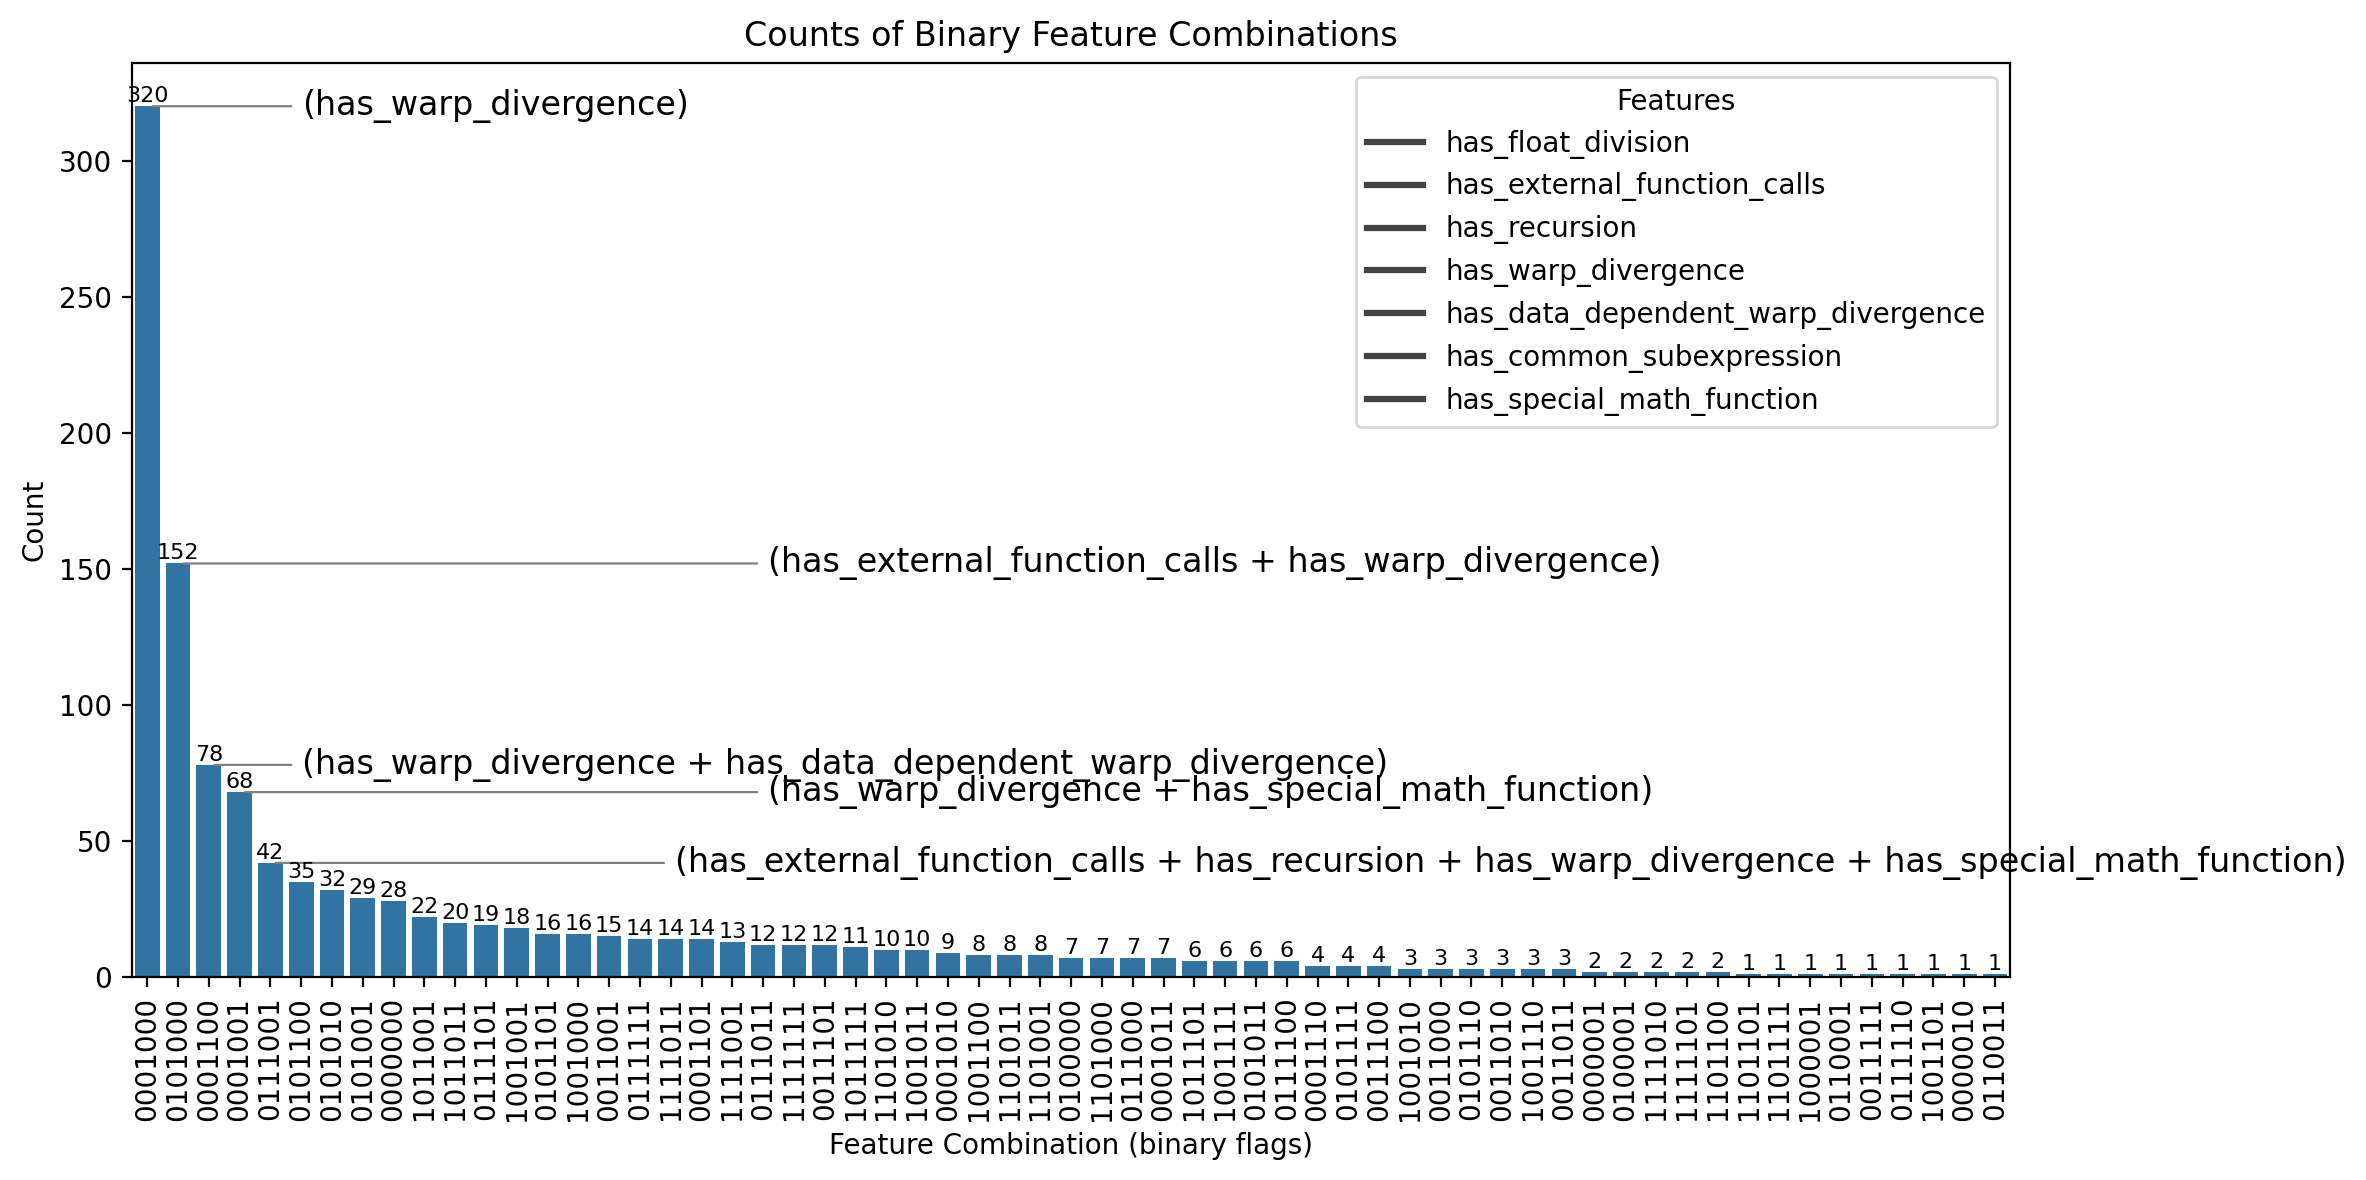

In [9]:
# Plot counts of each binary feature combination, sorted descending and excluding zeros
import textwrap
df_grouped_sorted = df_grouped[df_grouped['count'] > 0].sort_values(by='count', ascending=False)
# Create a label for each combination of binary flags
feature_cols = ['has_float_division', 'has_external_function_calls',
                'has_recursion', 'has_warp_divergence',
                'has_data_dependent_warp_divergence',
                'has_common_subexpression', 'has_special_math_function']
df_grouped_sorted['combination'] = df_grouped_sorted[feature_cols].apply(
    lambda row: ''.join(row.astype(int).astype(str)), axis=1)

plt.figure(figsize=(12, 6), dpi=200)
ax = sns.barplot(x='combination', y='count', data=df_grouped_sorted)
plt.title('Counts of Binary Feature Combinations')
plt.xlabel('Feature Combination (binary flags)')
plt.ylabel('Count')
plt.xticks(rotation=90, ha='center')

# Annotate feature tuples (first four only) at right edge inside plot with arrows, and counts above bars
xlim = ax.get_xlim()
ylim = ax.get_ylim()
# shift label_x slightly inside the right boundary
label_x = xlim[1] - (xlim[1] - xlim[0]) * 0.05
# define stagger offsets to prevent text overlap
stagger_offsets = [0, xlim[1]/4, 0, xlim[1]/4, xlim[1]/5]  # stagger offsets for the first five bars

for i, (p, (_, row)) in enumerate(zip(ax.patches, df_grouped_sorted.iterrows())):
    height = p.get_height()
    feature_names = [name for name, flag in zip(feature_cols, row[feature_cols]) if flag]
    tuple_text = f"({' + '.join(feature_names)})" if feature_names else '()'
    # draw arrow annotation for first five bars
    if i < 5:
        ax.annotate(tuple_text,
                    xy=(p.get_x() + p.get_width()/2, height),
                    xytext=(xlim[1]/12+stagger_offsets[i], height),
                    ha='left', va='center', color='black', fontsize=12,
                    arrowprops=dict(arrowstyle='-', color='gray', lw=0.8))
    # annotate count above bar
    ax.annotate(f"{int(height)}",
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', color='black', fontsize=8)

ax.legend(feature_cols, title='Features')
plt.tight_layout()
plt.show()

In [10]:
# Get the top feature combination
top_combination = df_grouped_sorted.iloc[3]

# Extract the feature columns used for grouping
feature_cols = ['has_float_division', 'has_external_function_calls', 
                'has_recursion', 'has_warp_divergence', 
                'has_data_dependent_warp_divergence',
                'has_common_subexpression', 'has_special_math_function']

# Create a boolean mask for the top combination
mask = (df_codes[feature_cols] == top_combination[feature_cols]).all(axis=1)

# Filter the original DataFrame to get the cases for the top combination
top_cases = df_codes[mask]


print("Source code for the first X cases of the top binary feature combination:")
for i, (index, row) in enumerate(top_cases.tail(10).iterrows()):
    feature_names = [name for name, flag in zip(feature_cols, row[feature_cols]) if flag]
    tuple_text = f"({', '.join(feature_names)})" if feature_names else '()'
    print(f"\n--- Case {i+1} ---")
    print(f"Program: {row['program_name']}")
    print(f"File: {row['filename']}, \nFeatures: {tuple_text}\n")
    print(row['source_code'])



Source code for the first X cases of the top binary feature combination:

--- Case 1 ---
Program: atomicPerf-cuda
File: /Users/gbolet/hecbench-roofline/src/atomicPerf-cuda/main.cu, 
Features: (has_warp_divergence, has_special_math_function)

#define T ((int)32)


__global__ void BlockRangeAtomicOnGlobalMem(T* data, int n)
{
  unsigned int tid = (blockIdx.x * blockDim.x) + threadIdx.x;
  for ( unsigned int i = tid; i < n; i += blockDim.x*gridDim.x){
    atomicAdd(data+threadIdx.x, (T)1);  //arbitrary number to add
  }
}

--- Case 2 ---
Program: atomicPerf-cuda
File: /Users/gbolet/hecbench-roofline/src/atomicPerf-cuda/main.cu, 
Features: (has_warp_divergence, has_special_math_function)

#define T ((int)32)


__global__ void WarpRangeAtomicOnGlobalMem(T* data, int n)
{
  unsigned int tid = (blockIdx.x * blockDim.x) + threadIdx.x;
  for ( unsigned int i = tid; i < n; i += blockDim.x*gridDim.x){
    atomicAdd(data+(i & 0x1F), (T)1); //arbitrary number to add
  }
}

--- Case 3 ---
Program: a

## Grab the target and kernel names of interest that we would want to query on

In [11]:
# these correspond to the "featureless" kernels
# and the ones that only have warp divergence
desired_feature_sets = ['0001000', '0000000']

# add a column with the binary feature set as a string
df_codes['binary_feature_set'] = df_codes[feature_cols].astype(int).astype(str).agg(''.join, axis=1)

desired_codes = df_codes[df_codes['binary_feature_set'].isin(desired_feature_sets)]

print(f"Number of codes with desired feature sets: {desired_codes.shape[0]}")
print(desired_codes['program_name'].head(10))

print(desired_codes.columns)

Number of codes with desired feature sets: 349
0      aligned-types-cuda
2     particlefilter-cuda
9                gmm-cuda
10               gmm-cuda
11               gmm-cuda
13           matrixT-cuda
14           matrixT-cuda
15           matrixT-cuda
16           matrixT-cuda
17           matrixT-cuda
Name: program_name, dtype: object
Index(['program_name', 'filename', 'source_code', 'code_hash',
       'has_float_division', 'float_division_line_num',
       'has_external_function_calls', 'external_function_call_line_num',
       'has_recursion', 'recursion_line_num', 'has_warp_divergence',
       'warp_divergence_line_num', 'has_data_dependent_warp_divergence',
       'data_dependent_warp_divergence_line_num', 'has_common_subexpression',
       'common_subexpression_line_num', 'has_special_math_function',
       'special_math_function_line_num', 'global_function_name',
       'combined_name', 'binary_feature_set'],
      dtype='object')


## Import the profiled kernel data

In [12]:
# we put a restriciton that the kernels must have a nonzero number of SP-FLOP or DP-FLOP operations

dtypes={'Kernel Name':'string', 
        'traffic':np.float64,
        'dpAI':np.float64,
        'spAI':np.float64,
        'dpPerf':np.float64,
        'spPerf':np.float64,
        'xtime':np.float64,
        'Block Size': 'string',
        'Grid Size': 'string',
        'device': 'string',
        "intops": np.float64, 
        "intPerf" : np.float64,
        "intAI": np.float64,
        'targetName': 'string',
        'exeArgs': 'string',
        'kernelName': 'string',
        }

# load the profiled kernels data
df = pd.read_csv('../../../roofline-data-new.csv', quotechar='"', dtype=dtypes)

# if we're loading old data that didn't gather intops
#df = pd.read_csv('../roofline-data-OLD-only-cuda.csv', quotechar='"', dtype=dtypes)
#df['intops'] = 0
#df['intPerf'] = 0
#df['intAI'] = 0

df['language'] = df['targetName'].apply(lambda x: 'CUDA' if '-cuda' in x else 'OMP')

# we only want the CUDA codes
df = df[df['language'] == 'CUDA']

# add a column with the combined_name
df['combined_name'] = df.apply(lambda row: f"({row['targetName']}, {row['kernelName']})", axis=1)

# xtime units of ns
# spPerf in units of OP/s
df['SP_FLOP'] = df['spPerf'] * 1e-9 * df['xtime']
df['SP_FLOP'] = df['SP_FLOP'].apply(int)

df['DP_FLOP'] = df['dpPerf'] * 1e-9 * df['xtime']
df['DP_FLOP'] = df['DP_FLOP'].apply(int)

print(df[(df['targetName'] == 'resize-cuda') & (df['kernelName'] == 'resize')]['SP_FLOP'])

print(df.shape)

1580    16779307
1581    16777662
Name: SP_FLOP, dtype: int64
(1647, 20)


In [13]:
# because a lot of these kernels were sampled twice, let's drop the first sample (which typically runs for longer than the second sample)
#grouped = df.groupby(by=['Kernel Name', 'kernelName', 'targetName', 'exeArgs'])['xtime'].min().reset_index()
#grouped = df.groupby(by=['Kernel Name', 'targetName', 'exeArgs'])['xtime'].min().reset_index()
grouped = df.groupby(by=['Kernel Name', 'targetName', 'exeArgs']).last().reset_index()

print(grouped.head())
print(grouped.shape)

df = grouped.reset_index(drop=True)

#df = df.merge(grouped, on=list(grouped.columns), how='inner')
#
#
print(df.columns)
print(df[['kernelName', 'Kernel Name']])
print(df.shape)

                                         Kernel Name           targetName  \
0  AESEncrypt(uchar4 *, const uchar4 *, const uch...             aes-cuda   
1  AIDW_Kernel(const float *, const float *, cons...            aidw-cuda   
2  AIDW_Kernel_Tiled(const float *, const float *...            aidw-cuda   
3  BP_queens_root_dfs(int, unsigned int, int, con...          nqueen-cuda   
4  BezierGPU(const XYZ *, XYZ *, int, int, int, int)  bezier-surface-cuda   

                                             exeArgs       traffic  dpAI  \
0                  100 0 ../urng-sycl/URNG_Input.bmp  1.664279e+09   0.0   
1                                           10 1 100  7.804676e+07   0.0   
2                                           10 1 100  9.264689e+07   0.0   
3                                           15 7 100  1.805783e+09   0.0   
4  ../face-cuda/Face.pgm ../face-cuda/info.txt .....  2.001762e+08   0.0   

           spAI  dpPerf        spPerf        xtime   Block Size  \
0      0.0000

## Overlap the profiled data with the desired codes

In [14]:
# should instead do this with targetName and kernelName

desired_kernels = desired_codes['combined_name'].unique()

# grab only the sampled kernels from our desired program names
matched_codes = df[df['combined_name'].isin(desired_kernels)]

#a = len(matched_codes['combined_name'].unique().tolist()) 
#b = matched_codes.shape[0]
#assert a == b, f"The number of unique combined names does not match the number of rows in the DataFrame. Please check the DataFrame. {a} != {b}"

# the total codes we are left with that we want to query on
print(matched_codes.shape)

(226, 20)


In [15]:
# let's double-check that the codes that weren't in the overlap are actually missing from the scraped kernels

# these were profiled codes
missing_codes = df[~df['combined_name'].isin(desired_kernels)]

print(missing_codes['combined_name'].unique()[:10])

['(aes-cuda, AESEncrypt)' '(aidw-cuda, AIDW_Kernel)'
 '(aidw-cuda, AIDW_Kernel_Tiled)' '(nqueen-cuda, BP_queens_root_dfs)'
 '(bezier-surface-cuda, BezierGPU)' '(bh-cuda, BoundingBoxKernel)'
 '(projectile-cuda, CalculateRange)' '(fpdc-cuda, CompressionKernel)'
 '(mriQ-cuda, ComputeQ_GPU)' '(fsm-cuda, FSMKernel)']


In [16]:
# manually checked a few of these and they do indeed do not meet the criteria of having only warp divergence or no features
kname_to_test = 'maxpool3d'
print(df[df['kernelName'] == kname_to_test])
print("\n\n")
print(desired_codes[desired_codes['global_function_name'] == kname_to_test])
print("\n\n")
print(df_codes[df_codes['global_function_name'] == kname_to_test])

                                           Kernel Name      targetName  \
410  maxpool3d(const float *, float *, int, int, in...  maxpool3d-cuda   

              exeArgs       traffic  dpAI  spAI  dpPerf  spPerf      xtime  \
410  2048 2048 96 100  7.203818e+11   0.0   0.0     0.0     0.0  2824640.0   

      Block Size     Grid Size                   device        intops  \
410  (16, 16, 1)  (64, 64, 96)  NVIDIA GeForce RTX 3080  6.140461e+09   

          intPerf     intAI kernelName language                combined_name  \
410  2.173892e+12  3.017694  maxpool3d     CUDA  (maxpool3d-cuda, maxpool3d)   

     SP_FLOP  DP_FLOP  
410        0        0  



Empty DataFrame
Columns: [program_name, filename, source_code, code_hash, has_float_division, float_division_line_num, has_external_function_calls, external_function_call_line_num, has_recursion, recursion_line_num, has_warp_divergence, warp_divergence_line_num, has_data_dependent_warp_divergence, data_dependent_warp_divergence_line_

## Load up the full scraped codes

In [17]:
file_path = '../../../analysis/simple-scraped-kernels-with-sass.json'

# Open and load the JSON file
with open(file_path, 'r') as file:
    src_data = json.load(file)

In [18]:
src_df = pd.DataFrame()
enc = tiktoken.encoding_for_model("gpt-4o-mini")

for target in tqdm(src_data, desc='Counting tokens'):
    basename = target['basename']
    kernelNames = target['kernelNames']
    for kern in kernelNames:
        statsDict = {'target':[basename], 'kernelName': [kern]}
        kernCtx = target['kernels'][kern]

        #sassKeys = list(target['sass'].keys())
        #kernSASS = ''
        #for key in sassKeys: 
        #    if kern in key: 
        #        kernSASS = target['sass'][key]
        #        break

        #print(kernCtx)
        encoded = enc.encode(kernCtx)
        statsDict['numTokens'] = [len(encoded)]

        #encoded = enc.encode(kernSASS)
        #statsDict['numTokensSASS'] = [len(encoded)]

        statsDict['source_code'] = [kernCtx]

        kernDF = pd.DataFrame.from_dict(statsDict).astype({'target': str, 'kernelName': str, 'numTokens': int, 'source_code': str})
        src_df = pd.concat([src_df, kernDF], ignore_index=True)

Counting tokens: 100%|██████████| 749/749 [00:37<00:00, 20.04it/s]


In [19]:
# drop the non-cuda kernels
src_df = src_df[src_df['target'].str.contains('-cuda')]

src_df['combined_name'] = src_df.apply(lambda row: f"({row['target']}, {row['kernelName']})", axis=1)
print(src_df.shape)
print(src_df.columns)
print(src_df.head(5))

(1151, 5)
Index(['target', 'kernelName', 'numTokens', 'source_code', 'combined_name'], dtype='object')
          target             kernelName  numTokens  \
0  accuracy-cuda        accuracy_kernel       1154   
2       ace-cuda    boundaryConditionsU       7879   
3       ace-cuda               swapGrid       7879   
4       ace-cuda         calculateForce       7879   
5       ace-cuda  boundaryConditionsPhi       7879   

                                         source_code  \
0  -----------------------------------\nmain.cu\n...   
2  -----------------------------------\nmain.cu\n...   
3  -----------------------------------\nmain.cu\n...   
4  -----------------------------------\nmain.cu\n...   
5  -----------------------------------\nmain.cu\n...   

                       combined_name  
0   (accuracy-cuda, accuracy_kernel)  
2    (ace-cuda, boundaryConditionsU)  
3               (ace-cuda, swapGrid)  
4         (ace-cuda, calculateForce)  
5  (ace-cuda, boundaryConditionsPhi)  


## Emit dataset + check stats

In [20]:
# these are the kernels we will move forward with, if we want to add more, we will need to sample more
print(matched_codes.shape)
print(matched_codes.columns)

(226, 20)
Index(['Kernel Name', 'targetName', 'exeArgs', 'traffic', 'dpAI', 'spAI',
       'dpPerf', 'spPerf', 'xtime', 'Block Size', 'Grid Size', 'device',
       'intops', 'intPerf', 'intAI', 'kernelName', 'language', 'combined_name',
       'SP_FLOP', 'DP_FLOP'],
      dtype='object')


In [21]:
# drop the rows with 0 SP-FLOP and 0 DP-FLOP

nonzero_flop_kernels = matched_codes[(matched_codes['SP_FLOP'] > 0) | (matched_codes['DP_FLOP'] > 0)]
print(nonzero_flop_kernels.shape)

# resize cuda technically has special math function calls, but we should include it
# as we've already been able to predict well on it
print(nonzero_flop_kernels[nonzero_flop_kernels['targetName'] == 'resize-cuda'])

(96, 20)
Empty DataFrame
Columns: [Kernel Name, targetName, exeArgs, traffic, dpAI, spAI, dpPerf, spPerf, xtime, Block Size, Grid Size, device, intops, intPerf, intAI, kernelName, language, combined_name, SP_FLOP, DP_FLOP]
Index: []


In [22]:
# merge the src_df with nonzero_flop_kernels
merged_df = pd.merge(src_df, nonzero_flop_kernels, on=['combined_name'], how='inner')


print(merged_df.shape)
print(merged_df.columns)


assert merged_df[merged_df['kernelName_x'] != merged_df['kernelName_y']].shape[0] == 0, "Kernel names do not match after merge!"

assert merged_df[merged_df['target'] != merged_df['targetName']].shape[0] == 0, "Target names do not match after merge!"


(96, 24)
Index(['target', 'kernelName_x', 'numTokens', 'source_code', 'combined_name',
       'Kernel Name', 'targetName', 'exeArgs', 'traffic', 'dpAI', 'spAI',
       'dpPerf', 'spPerf', 'xtime', 'Block Size', 'Grid Size', 'device',
       'intops', 'intPerf', 'intAI', 'kernelName_y', 'language', 'SP_FLOP',
       'DP_FLOP'],
      dtype='object')


In [23]:
# rearrange the columns so source_code is last

cols = [c for c in merged_df.columns if c != 'source_code'] + ['source_code']
merged_df = merged_df[cols]

In [24]:
print(merged_df.columns)
print(len(merged_df.columns))
print(merged_df.dtypes)

Index(['target', 'kernelName_x', 'numTokens', 'combined_name', 'Kernel Name',
       'targetName', 'exeArgs', 'traffic', 'dpAI', 'spAI', 'dpPerf', 'spPerf',
       'xtime', 'Block Size', 'Grid Size', 'device', 'intops', 'intPerf',
       'intAI', 'kernelName_y', 'language', 'SP_FLOP', 'DP_FLOP',
       'source_code'],
      dtype='object')
24
target                   object
kernelName_x             object
numTokens                 int64
combined_name            object
Kernel Name      string[python]
targetName       string[python]
exeArgs          string[python]
traffic                 float64
dpAI                    float64
spAI                    float64
dpPerf                  float64
spPerf                  float64
xtime                   float64
Block Size       string[python]
Grid Size        string[python]
device           string[python]
intops                  float64
intPerf                 float64
intAI                   float64
kernelName_y     string[python]
language       

In [25]:
assert merged_df.shape[0] > 0, "The DataFrame is empty. Please check the CSV file path and content."

assert merged_df.language.isin(['CUDA']).all(), "All kernels should be in CUDA language. Please check the DataFrame."

assert ((merged_df['SP_FLOP'] + merged_df['DP_FLOP']) > 0).all(), "All kernels should have non-zero FLOP counts. Please check the DataFrame."


grouped = merged_df.groupby('combined_name').size().reset_index(name='counts')
# find the group with more than one row
duplicates = grouped[grouped['counts'] > 1]
print(duplicates)

a = len(merged_df['combined_name'].unique().tolist()) 
b = merged_df.shape[0]
assert a == b, f"The number of unique combined names does not match the number of rows in the DataFrame. Please check the DataFrame. {a} != {b}"

Empty DataFrame
Columns: [combined_name, counts]
Index: []


## Save the Dataframe

In [26]:
merged_df.to_csv('./kernels_to_inference.csv', quoting=csv.QUOTE_NONNUMERIC, quotechar='"', index=False, na_rep='NULL')

NOTE: Had to manually modify (srad-cuda, srad2) to use the proper kernel name of "srad2" instead of "srad" which was triggering the above assertion error. This manual modification was done to the output CSV. Note sure where the name was incorrectly pulled, not going to spend time figuring it out right now.
From what I can see though, it came from the roofline-data-new.csv dataset, which might indicate a bug in the "kernelName" column extraction.

I simply updated the kernelName for the incorrect srad2 datapoint column value from out "roofline-data-new.csv" file to get rid of the error.